## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/FA/1.2_gender_input_output
! ls

/content/drive/My Drive/Colab Notebooks/FA/1.2_gender_input_output
input  output


## Import Libraries/ Functions

In [ ]:
# Imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cv2
import os

import tensorflow as tf

from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPooling2D,AvgPool2D,GlobalAveragePooling2D,Dense,Dropout,BatchNormalization,Flatten,Input
from sklearn.model_selection import train_test_split


from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

## Import Dataset

In [ ]:


path = "./input/UTKFace"
pixels = []
age = []
gender = []

i=0
for img in os.listdir(path):
  i=i+1
  genders = img.split("_")[1]
  img = cv2.imread(str(path)+"/"+str(img))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img=cv2.resize(img,(100,100))
  pixels.append(np.array(img))
  gender.append(np.array(genders))

pixels = np.array(pixels)
gender = np.array(gender,np.uint64)

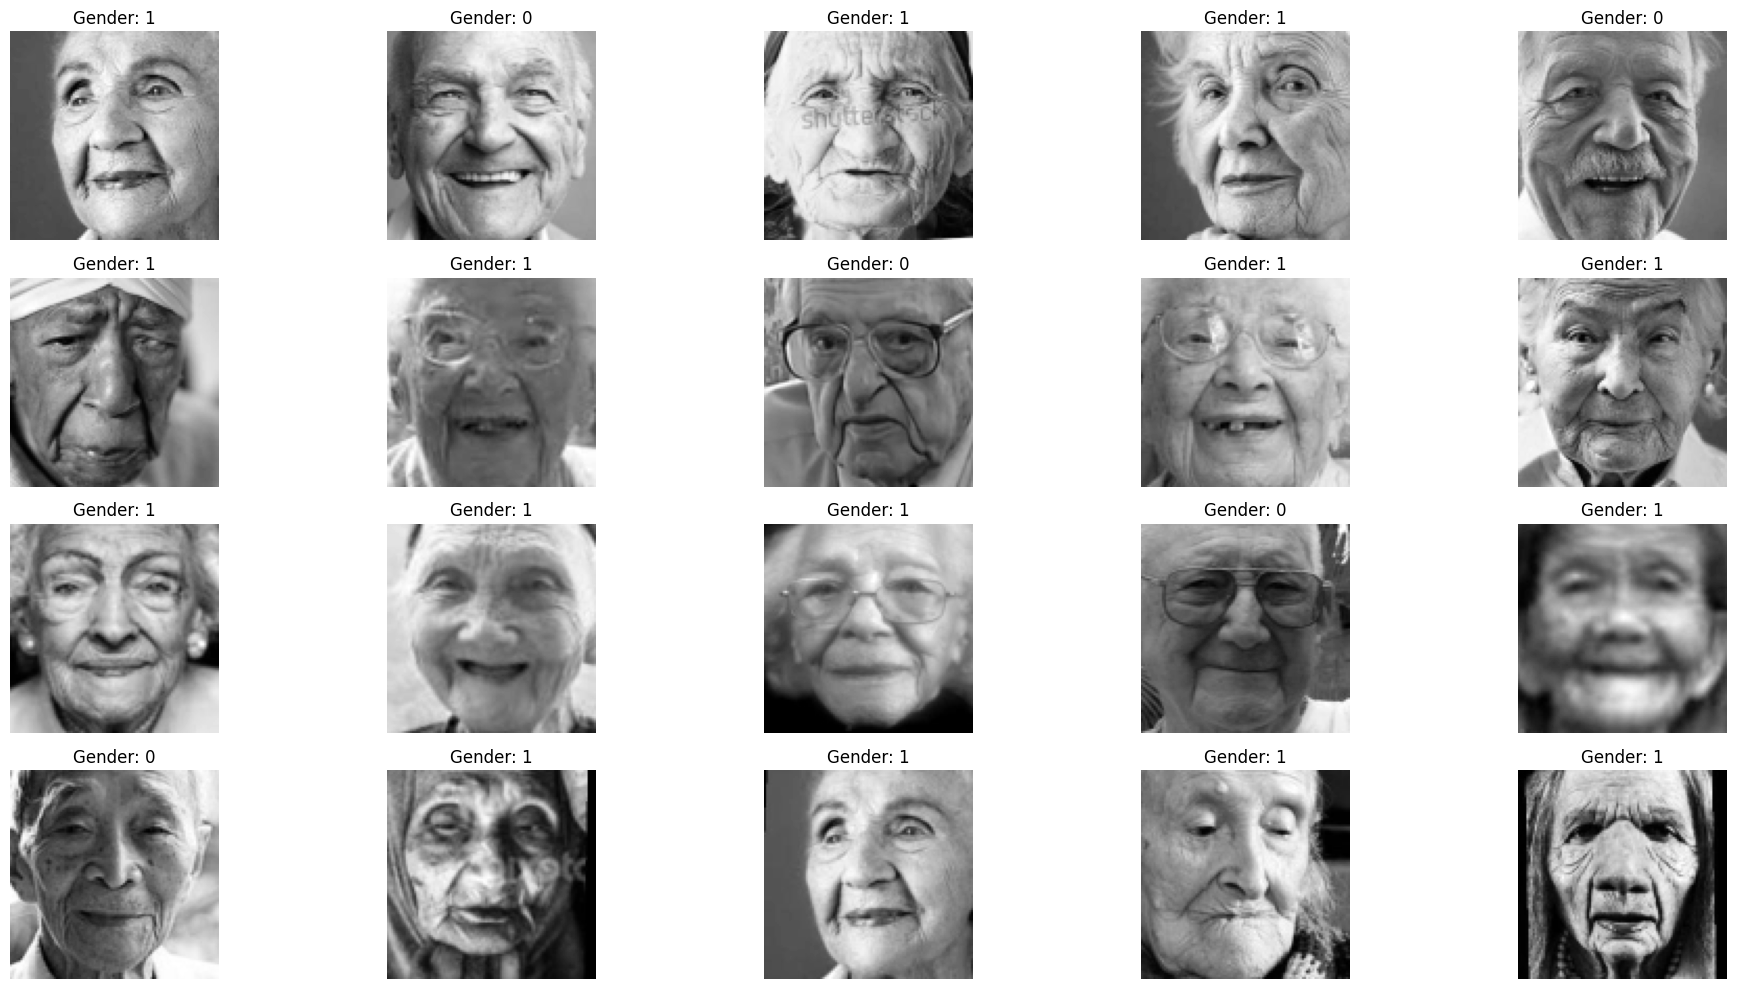

In [ ]:
# prompt: give a code for display 20 images

import matplotlib.pyplot as plt

# Assuming pixels and gender are already defined from your previous code

plt.figure(figsize=(20, 10))
for i in range(20):
  plt.subplot(4, 5, i + 1)
  plt.imshow(pixels[i], cmap='gray')
  plt.title(f'Gender: {gender[i]}')
  plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
len(pixels)

23708

In [ ]:
len(gender)

23708

In [ ]:
# prompt: give  code for feature extraction using CNN

# Define the CNN model for feature extraction
def create_feature_extractor(input_shape=(100, 100, 1)):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  return model

# Create the feature extractor model
feature_extractor = create_feature_extractor()

# Extract features from the images
features = feature_extractor.predict(pixels.reshape(-1, 100, 100, 1))

# Now you have 'features' which is a numpy array containing the extracted features
# You can use these features for further processing like classification or clustering
print(features.shape)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
(921, 12800)


## Split into Train/ Test

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(pixels,gender,random_state=100)

In [ ]:
len(x_train)

17781

In [ ]:
len(x_test)

5927

## Define CNN Architecture

In [ ]:
input = Input(shape = (100,100,1))

conv1 = Conv2D(32,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(input)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size = (2,2)) (conv1)

conv2 = Conv2D(64,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size = (2,2)) (conv2)

conv3 = Conv2D(128,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size = (2,2)) (conv3)

conv4 = Conv2D(256,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size = (2,2)) (conv4)

flatten = Flatten()(pool4)

dense_1 = Dense(128,activation='relu')(flatten)

drop_1 = Dropout(0.2)(dense_1)

output = Dense(2,activation="sigmoid")(drop_1)

In [ ]:
model = Model(inputs=input,outputs=output)
model.compile(optimizer="adam",loss=["sparse_categorical_crossentropy"],metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 dropout (Dropout)           (None, 100, 100, 32)      0         
                                                                 
 activation (Activation)     (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                             

In [ ]:
model_path='./output/gender_model.h5'
checkpointer = ModelCheckpoint(model_path, monitor='loss',verbose=1,save_best_only=True,
                               save_weights_only=False, mode='auto',save_freq='epoch')
callback_list=[checkpointer]

## Model Training

In [ ]:
save = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=30,callbacks=[callback_list])

Epoch 1/30
556/556 [==============================] - ETA: 0s - loss: 1.4473 - accuracy: 0.7400
Epoch 00001: loss improved from inf to 1.44726, saving model to ./output/gender_model.h5
556/556 [==============================] - 18s 15ms/step - loss: 1.4473 - accuracy: 0.7400 - val_loss: 0.5918 - val_accuracy: 0.8365
Epoch 2/30
553/556 [============================>.] - ETA: 0s - loss: 0.5432 - accuracy: 0.8331
Epoch 00002: loss improved from 1.44726 to 0.54325, saving model to ./output/gender_model.h5
556/556 [==============================] - 7s 13ms/step - loss: 0.5432 - accuracy: 0.8330 - val_loss: 0.4894 - val_accuracy: 0.8650
Epoch 3/30
554/556 [============================>.] - ETA: 0s - loss: 0.4769 - accuracy: 0.8590
Epoch 00003: loss improved from 0.54325 to 0.47648, saving model to ./output/gender_model.h5
556/556 [==============================] - 7s 13ms/step - loss: 0.4765 - accuracy: 0.8590 - val_loss: 0.4378 - val_accuracy: 0.8708
Epoch 4/30
556/556 [====================

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = save.history['loss']
test_loss = save.history['val_loss']
train_accuracy = save.history['accuracy']
test_accuracy = save.history['val_accuracy']

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

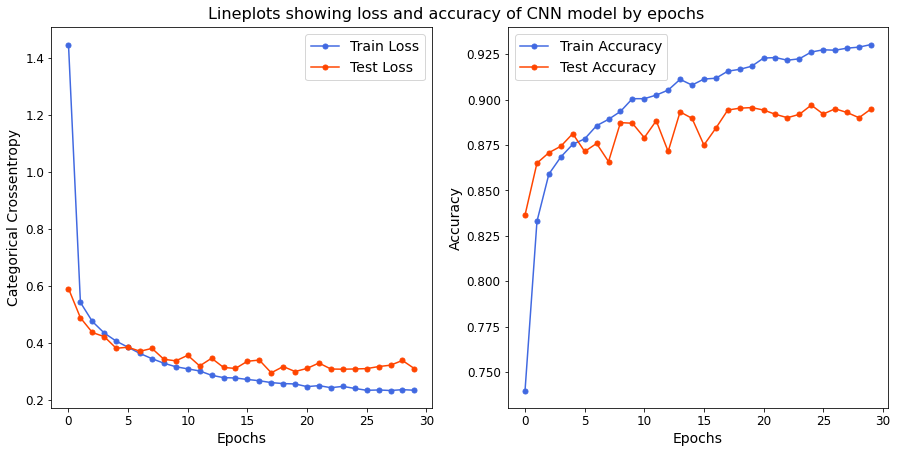

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)